<div style="background: navy; color: white; padding: 20px">

# $\S 7$: Clustering market regimes using the rank-$r$ MMD

## Z Issa Apr 2023

In this notebook, we outline how the rank-$r$ MMD can be used to cluster market regimes on pathspace.

### Background.

<div style="background: navy; color: white; padding: 20px">

### Imports

In [1]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering

from src.generators.Model import Model
from src.generators.config import ModelConfig
from src.testing import TestConfig
from src.testing.clustering.config import ClusterConfig
from src.testing.discriminators import AutoEvaluator
from src.testing.discriminators.config import ProcessorConfig
from src.testing.experiment_functions.plot_result_functions import plot_path_experiment_result
from src.utils.Config import Config
from src.utils.auxiliary_classes.PathTransformer import PathTransformer, PathTransformerConfig
from src.utils.auxiliary_classes.RegimePartitioner import RegimePartitioner, RegimePartitionerConfig
from src.utils.helper_functions.plot_helper_functions import plot_regime_change_path
from src.utils.helper_functions.test_helper_functions import get_memberships, get_sub_paths, get_grouped_paths

<div style="background: navy; color: white; padding: 20px">

### 1. Set configurations

In [16]:
test_config             = TestConfig()
cluster_config          = ClusterConfig()
path_transformer_config = PathTransformerConfig()
processor_config        = ProcessorConfig()
model_config            = ModelConfig()
regime_config           = RegimePartitionerConfig()

model_config.year_mesh         = 7*252
model_config.attach_volatility = False

n_steps = 8
n_paths = 16
offset  = 0
T       = 2
dim     = 1
dt      = 1/model_config.year_mesh

S0 = [1. for _ in range(dim)]

test_config.override_args({
    "n_steps": n_steps,
    "n_paths": n_paths,
    "offset" : offset,
    "weight_factor": 1,
    "belief_models": ["gbm"],
    "model_pair_names": ["gbm", "gbm"],
    "belief_params": [[[0., 0.2] for _ in range(dim)]],
    "model_pair_params": [[[0., 0.2] for _ in range(dim)], [[0., 0.3] for _ in range(dim)]],
    "path_bank_size": 100000
})

path_transformer_config.set_transformations({
    "standardise_path_transform":    (True,  0, {"s_type": "initial"}),
    "time_normalisation_transform":  (True,  0, {}),
    "translation_transform":         (True,  0, {}),
    "difference_transform":          (False, 0, {}),
    "squared_log_returns_transform": (False, 0, {}),
    "ewma_volatility_transform"    : (False, 0, {"lambd": 0.5}),
    "cumulant_transform":            (False, 2, {}),
    "increment_transform":           (True, 2, {}),
    "lead_lag_transform":            (False, 3, {}),
    "invisibility_transform":        (False, 4, {}),
})

path_transformer_config.compute_pathwise_signature_transform = False
path_transformer_config.signature_order = 8

path_transformer = PathTransformer(path_transformer_config)

processor_config.autoevaluator_kwargs.override_args({
    "metric_kwargs": Config(**{
        "kernel_type": "rbf",
        "metric_type": "mmd",
        "sigmas": [5e-1],  
        "dyadic_orders": [3],  
        "lambd": 1
    })
})

regime_config.override_args({
    "n_regime_changes": 5,
    "f_length_scale"  : 0.5, 
    "type"            : "random_on_off_steps", 
    "r_on_args"       : ["poisson", 4],
    "r_off_args"      : ["poisson", 1/7],
    "r_min_distance"  : 20
})

<div style="background: navy; color: white; padding: 20px">

### 2. Initialize detector (classifier)

In [17]:
classifier = AutoEvaluator(
    path_transformer = path_transformer,
    processor_config = processor_config,
    test_config      = test_config
)

Metric initialised. MMD1, sigma = 0.5000, dyadic_order = 3


<div style="background: navy; color: white; padding: 20px">


### 3. Build and plot regime-changed path

In [18]:
regime_partitioner = RegimePartitioner(model_config.year_mesh, regime_config)
regime_partitioner.generate_regime_partitions(T=T, n_steps=n_steps)

model_pair_names, model_pair_params = test_config.model_pair_names, test_config.model_pair_params
model_pairs                         = [Model(name, theta, model_config) for name, theta in zip(model_pair_names, model_pair_params)]

cluster_path = regime_partitioner.generate_regime_change_path(model_pairs, S0)

_, regime_changes, _ = regime_partitioner.changes_to_times()
path_splits_time = [item for sublist in [[r[0], r[1] + 1/model_config.year_mesh] for r in regime_changes] for item in sublist] 
path_splits_mesh = [int(p*model_config.year_mesh) for p in path_splits_time]

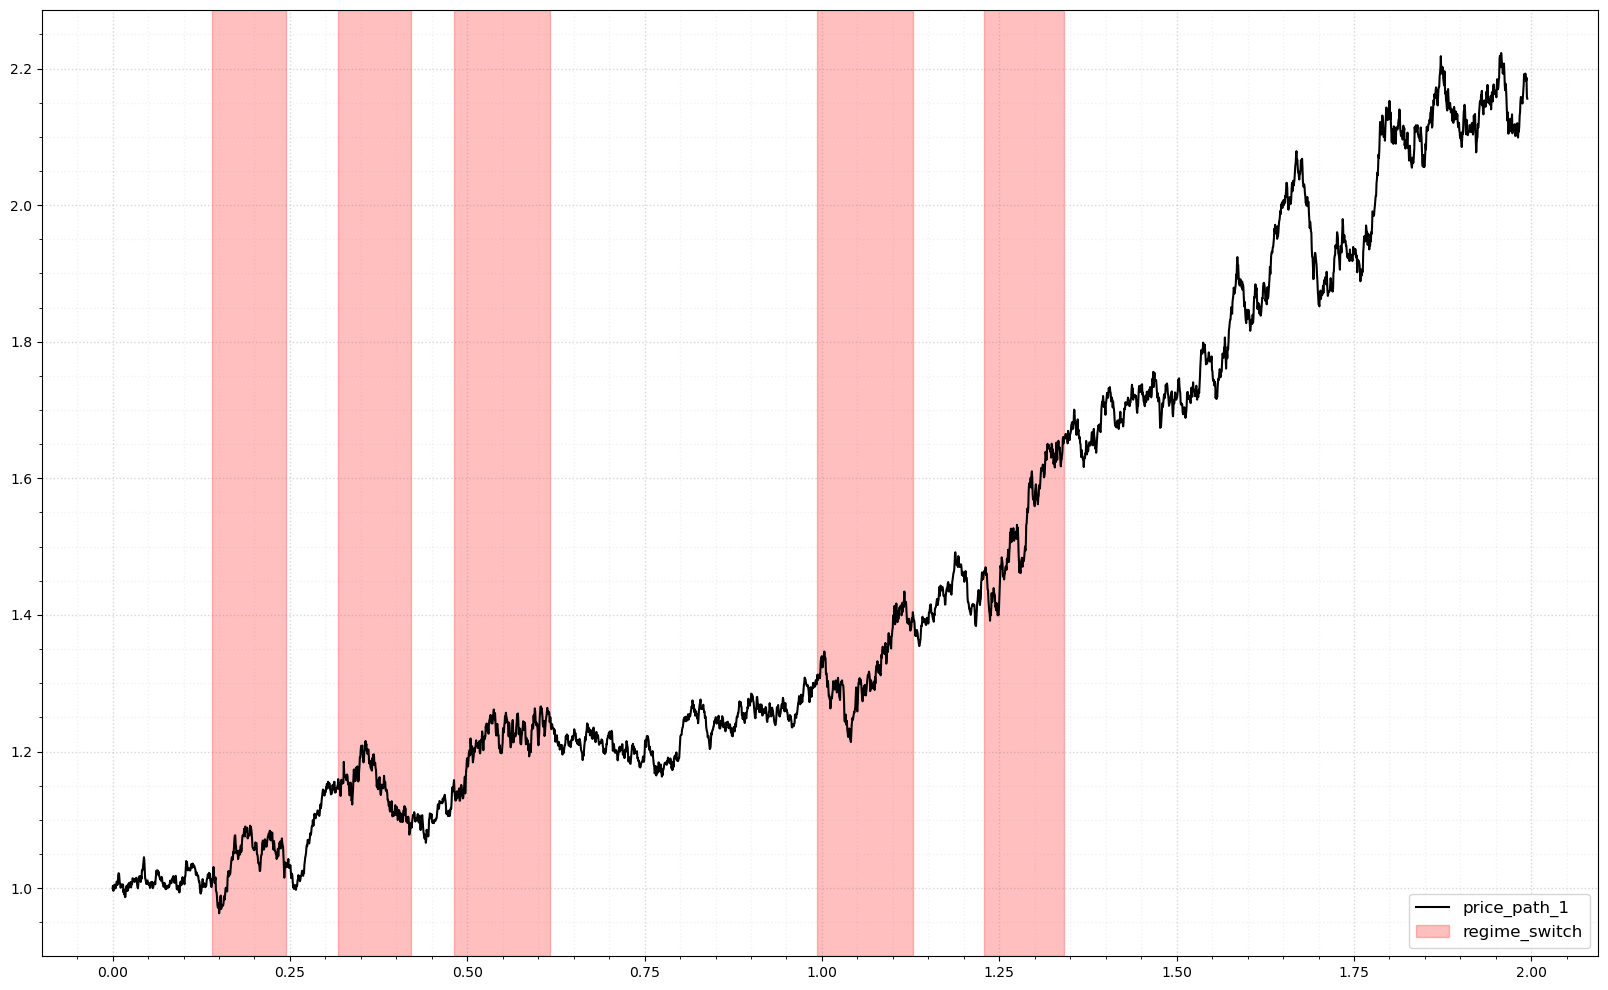

In [19]:
plot_regime_change_path(cluster_path, regime_changes, log_returns=False, one_dim=True)

<div style="background: navy; color: white; padding: 20px">

### 4. Get pairwise distance matrix

In [20]:
pairwise_distance_matrix = classifier.generate_distance_matrix(cluster_path)

100%|██████████| 426/426 [03:54<00:00,  1.81it/s]


<div style="background: navy; color: white; padding: 20px">

### 5. Get clusters from <code>AgglomerativeClustering</code>

In [21]:
clusters_object = AgglomerativeClustering(
    n_clusters = 2, 
    affinity   = "precomputed", 
    linkage    = "average"
).fit(pairwise_distance_matrix)

labels_ = clusters_object.labels_

<div style="background: navy; color: white; padding: 20px">

### 6. Plot results

In [22]:
sp_cluster = get_sub_paths(cluster_path, n_steps, 0)
mmd_cluster = get_grouped_paths(sp_cluster, n_paths)
sp_cluster_t = path_transformer.transform_paths(sp_cluster.copy())
mmd_cluster_t = get_grouped_paths(sp_cluster_t, n_paths)

100%|██████████| 441/441 [00:00<00:00, 43802.41it/s]


In [23]:
indexes               = sp_cluster[:, -1, 0]
cluster_memberships   = get_memberships(mmd_cluster)

scores                = np.array([np.mean(labels_[m]) for m in cluster_memberships])
cluster_score_array   = np.vstack([indexes, scores])

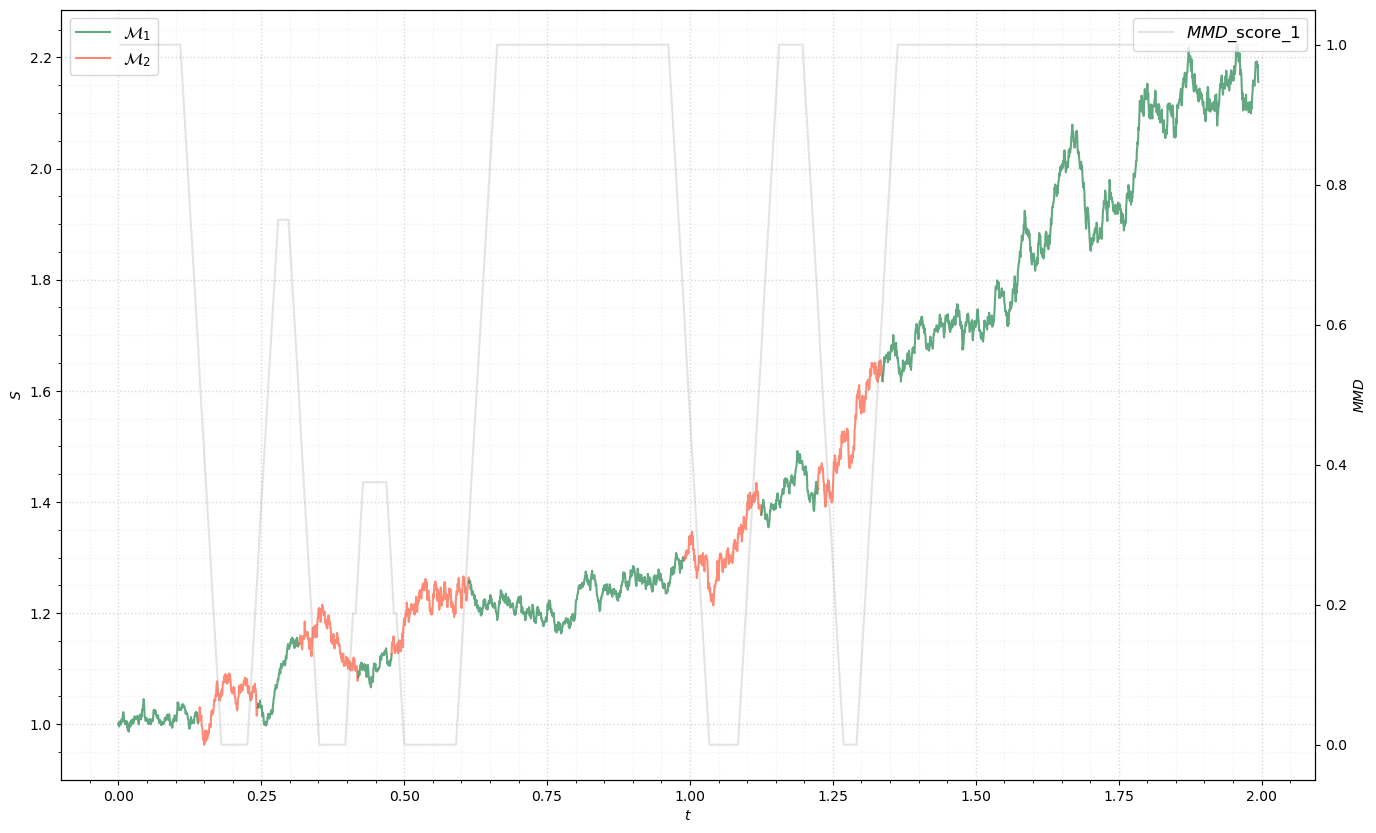

In [24]:
plot_path_experiment_result(cluster_path, cluster_score_array, path_splits_mesh, diff=False, one_dim=True)